# WASP-140 analysis
Author: Néstor Espinoza (nespinoza@stsci.edu)

Let's start by importing relevant libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

import juliet

Let's download the WASP-140 lightcurves:

In [2]:
t,f,ferr = juliet.get_all_TESS_data('WASP-140b')

Which sector is this data from?

In [3]:
t.keys()

dict_keys(['TESS4', 'TESS5'])

Sectors 4 and 5. Let's see how this data looks like:

(0.9066200768575072, 54.27462618006393)

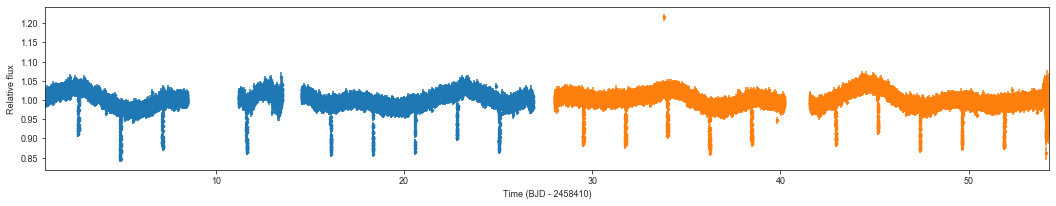

In [4]:
tstart = np.inf
tend = -np.inf
plt.figure(figsize=(18,3))
for sector in t.keys():
    ct, cf, cferr = t[sector], f[sector], ferr[sector]
    if np.min(ct)<tstart:
        tstart = np.min(ct)
    if np.max(ct)>tend:
        tend = np.max(ct)
    plt.errorbar(ct-int(tstart), cf, cferr,fmt='.')
plt.xlabel(f'Time (BJD - {int(tstart)})')
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])

Hmmmm. Transits look _very_ deep. Like _10\%_ deep, which is definitely too much (e.g., ground-based follow-up clearly captures depth variations of 2\%). A quick look at the targets in the field with Aladin reveals that WASP-140 (the star) has a companion star which should dilute the TESS transits.  The companion star has a Gaia RP flux of $F_{RP,C} = 9911.51$; the target star (WASP-140) has a flux of $F_{RP,T} = 63036.4$. That would imply a dilution factor of $D = 1/(1 + (F_{RP,C}/F_{RP,T})) \sim 0.86$. So if the (real) transit depth is 2\%, the measured (diluted) transit depth should be around 1.72\% --- not 10\%. 

Could it be that we downloaded the wrong target? Let's try downloading the data for TIC 178284730, which is the TIC ID for WASP-140b:

In [5]:
t,f,ferr = juliet.get_all_TESS_data('TIC 178284730')

(0.9066201820969582, 54.27462609810755)

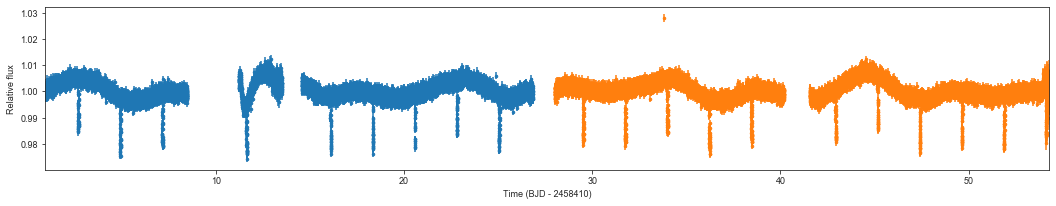

In [6]:
t.keys()
tstart = np.inf
tend = -np.inf
plt.figure(figsize=(18,3))
for sector in t.keys():
    ct, cf, cferr = t[sector], f[sector], ferr[sector]
    if np.min(ct)<tstart:
        tstart = np.min(ct)
    if np.max(ct)>tend:
        tend = np.max(ct)
    plt.errorbar(ct-int(tstart), cf, cferr,fmt='.')
plt.xlabel(f'Time (BJD - {int(tstart)})')
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])

Ah! Much better. We indeed messed up downloading the data. With this solved, let's get to the fitting:

## Fitting it like in the paper

In the paper this is fit using a more or less strict period and time-of-transit center prior based on [Hellier et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.465.3693H/abstract). Notice the orbit is slightly eccentric --- perhaps it is not very important? Let's see if we obtain the same results as in the paper here; we let the dilution factor wander around freely between 0.8 and 1:

In [7]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS4_TESS5','q2_TESS4_TESS5','ecc_p1','omega_p1',\
          'a_p1', 'mdilution_TESS4_TESS5', 'mflux_TESS4', 'sigma_w_TESS4', 'GP_sigma_TESS4', 'GP_rho_TESS4', \
          'GP_timescale_TESS4', 'mflux_TESS5', 'sigma_w_TESS5', 'GP_sigma_TESS5', 'GP_rho_TESS5', \
          'GP_timescale_TESS5']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
         'loguniform', 'uniform', 'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform',\
         'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[2.2359835, 0.0000008], [2456912.35105,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
           [1,100.], [0.8,1.], [0.,0.1], [0.1, 10000.], [0.1, 10000.], [0.001, 10000.], [0.001, 10000.], \
           [0.,0.1], [0.1, 10000.], [0.1, 10000.], [0.001, 10000.], [0.001, 10000.]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [8]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = t, y_lc = f, \
                      yerr_lc = ferr, GP_regressors_lc = t, out_folder = 'WASP-140b-ExpMatern')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 500)

  analysing data from WASP-140b-ExpMatern/jomnest_.txt


Let's see how the fit looks like:

(-5000, 5000)

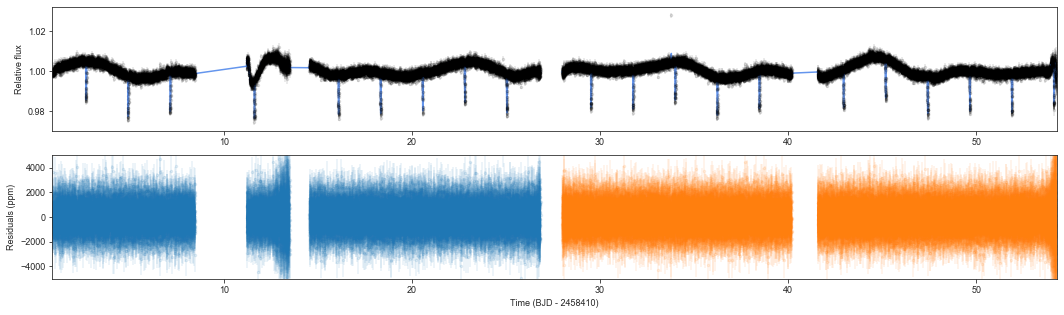

In [13]:
plt.figure(figsize=(18,5))

plt.subplot(211)
# Plot the data:
models = {}
components = {}
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)

    # Plot the model:
    models[sector], components[sector] = results.lc.evaluate(sector, return_components=True)
    plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],color='cornflowerblue')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.subplot(212)
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), (dataset.data_lc[sector] - models[sector])*1e6, \
             yerr = dataset.errors_lc[sector]*1e6, fmt = '.', alpha = 0.1)
    plt.ylabel('Residuals (ppm)')
    plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.ylim([-5000,5000])

(0.975, 1.01)

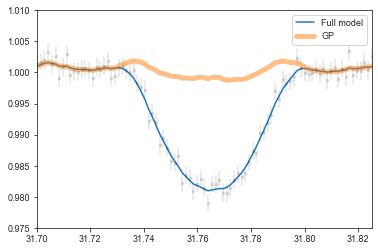

In [14]:
plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)
plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],label='Full model')
plt.plot(dataset.times_lc[sector]-int(tstart), models[sector]/components[sector]['transit'],'-',lw=5,alpha=0.5,label='GP')
plt.legend()
plt.xlim(31.7,31.825)
plt.ylim(0.975,1.01)

Dilution factor, transit depth?

(array([  1.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   3.,
          2.,   4.,   5.,   3.,   3.,   4.,   3.,   6.,   5.,   2.,   7.,
          8.,   8.,   4.,  11.,  12.,  11.,  12.,   9.,  13.,  16.,  14.,
         19.,  17.,  16.,  13.,  17.,  14.,  18.,  12.,  22.,  17.,  18.,
         21.,  27.,  32.,  19.,  21.,  19.,  21.,  29.,  24.,  26.,  32.,
         28.,  32.,  34.,  57.,  54.,  46.,  60.,  79.,  95., 114., 141.,
        194., 231., 240., 265., 344., 328., 381., 337., 393., 371., 317.,
        339., 291., 369., 327., 267., 279., 197., 151., 137., 103.,  71.,
         54.,  39.,  26.,  16.,  10.,   4.,   9.,   2.,   5.,   1.,   0.,
          4.]),
 array([0.82498994, 0.82673184, 0.82847374, 0.83021565, 0.83195755,
        0.83369945, 0.83544135, 0.83718325, 0.83892516, 0.84066706,
        0.84240896, 0.84415086, 0.84589277, 0.84763467, 0.84937657,
        0.85111847, 0.85286038, 0.85460228, 0.85634418, 0.85808608,
        0.85982798, 0.86156989, 0.86331179, 0.

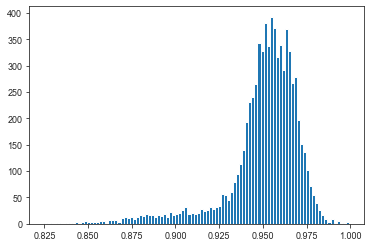

In [15]:
plt.hist(results.posteriors['posterior_samples']['mdilution_TESS4_TESS5'],bins=100)

In [19]:
b,p = juliet.utils.reverse_bp(results.posteriors['posterior_samples']['r1_p1'], results.posteriors['posterior_samples']['r2_p1'],0.,1.)

Text(0, 0.5, '$R_p/R_*$')

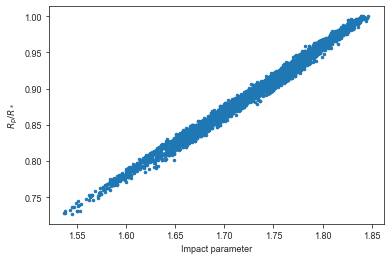

In [20]:
plt.plot(b,p,'.')
plt.xlabel('Impact parameter')
plt.ylabel('$R_p/R_*$')

What about fixed dilution?

In [21]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS4_TESS5','q2_TESS4_TESS5','ecc_p1','omega_p1',\
          'a_p1', 'mdilution_TESS4_TESS5', 'mflux_TESS4', 'sigma_w_TESS4', 'GP_sigma_TESS4', 'GP_rho_TESS4', \
          'GP_timescale_TESS4', 'mflux_TESS5', 'sigma_w_TESS5', 'GP_sigma_TESS5', 'GP_rho_TESS5', \
          'GP_timescale_TESS5']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
         'loguniform', 'fixed', 'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform',\
         'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[2.2359835, 0.0000008], [2456912.35105,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
           [1,100.], 1.0, [0.,0.1], [0.1, 10000.], [0.1, 10000.], [0.001, 10000.], [0.001, 10000.], \
           [0.,0.1], [0.1, 10000.], [0.1, 10000.], [0.001, 10000.], [0.001, 10000.]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [22]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = t, y_lc = f, \
                      yerr_lc = ferr, GP_regressors_lc = t, out_folder = 'WASP-140b-ExpMatern-fixed-dilution')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 500)

  analysing data from WASP-140b-ExpMatern-fixed-dilution/jomnest_.txt


(-5000, 5000)

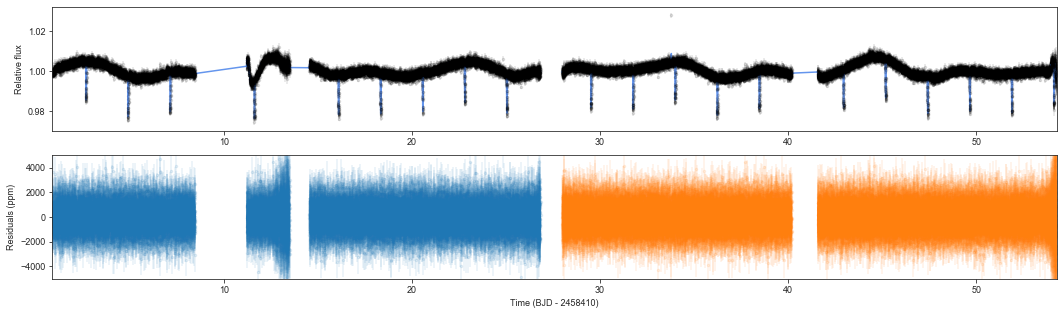

In [23]:
plt.figure(figsize=(18,5))

plt.subplot(211)
# Plot the data:
models = {}
components = {}
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)

    # Plot the model:
    models[sector], components[sector] = results.lc.evaluate(sector, return_components=True)
    plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],color='cornflowerblue')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.subplot(212)
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), (dataset.data_lc[sector] - models[sector])*1e6, \
             yerr = dataset.errors_lc[sector]*1e6, fmt = '.', alpha = 0.1)
    plt.ylabel('Residuals (ppm)')
    plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.ylim([-5000,5000])

In [24]:
b,p = juliet.utils.reverse_bp(results.posteriors['posterior_samples']['r1_p1'], results.posteriors['posterior_samples']['r2_p1'],0.,1.)

Text(0, 0.5, '$R_p/R_*$')

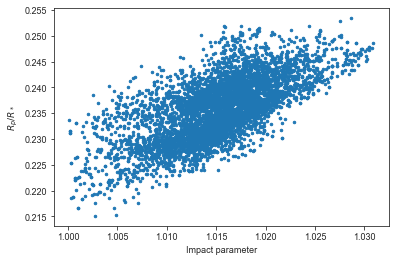

In [25]:
plt.plot(b,p,'.')
plt.xlabel('Impact parameter')
plt.ylabel('$R_p/R_*$')

(0.975, 1.01)

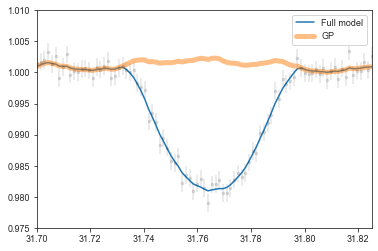

In [26]:
plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)
plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],label='Full model')
plt.plot(dataset.times_lc[sector]-int(tstart), models[sector]/components[sector]['transit'],'-',lw=5,alpha=0.5,label='GP')
plt.legend()
plt.xlim(31.7,31.825)
plt.ylim(0.975,1.01)

**That's actually better**, so probably dilution was taken care of by the PDC lightcurve. However, $R_p/R_*$ and the impact parameter, $b$, do not match the values from [Hellier et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.465.3693H/abstract). There they report $R_p/R_* = 0.1427 \pm 0.0071$ and $b = 0.93^{+0.07}_{-0.03}$. What if we try this last fit once again, but considering a prior on the eccentricity as the one set by that work? $e = 0.0470 \pm 0.0035$, $\omega = -4 \pm 8$.

### Fit with eccentricity prior

In [7]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS4_TESS5','q2_TESS4_TESS5','ecc_p1','omega_p1',\
          'a_p1', 'mdilution_TESS4_TESS5', 'mflux_TESS4', 'sigma_w_TESS4', 'GP_sigma_TESS4', 'GP_rho_TESS4', \
          'GP_timescale_TESS4', 'mflux_TESS5', 'sigma_w_TESS5', 'GP_sigma_TESS5', 'GP_rho_TESS5', \
          'GP_timescale_TESS5']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
         'loguniform', 'fixed', 'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform',\
         'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[2.2359835, 0.0000008], [2456912.35105,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0470, 0.,\
           [1,100.], 1.0, [0.,0.1], [0.1, 10000.], [0.1, 10000.], [0.001, 10000.], [0.001, 10000.], \
           [0.,0.1], [0.1, 10000.], [0.1, 10000.], [0.001, 10000.], [0.001, 10000.]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [8]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = t, y_lc = f, \
                      yerr_lc = ferr, GP_regressors_lc = t, out_folder = 'WASP-140b-ExpMatern-fixed-dilution-with-ecc')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 500)

  analysing data from WASP-140b-ExpMatern-fixed-dilution-with-ecc/jomnest_.txt


(-5000, 5000)

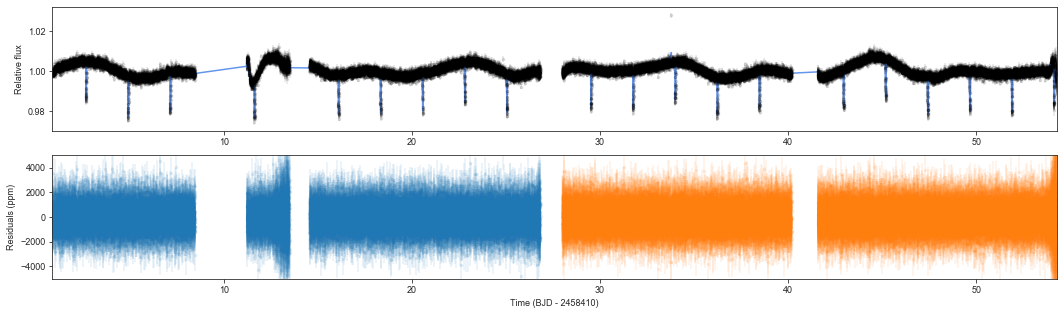

In [9]:
plt.figure(figsize=(18,5))

plt.subplot(211)
# Plot the data:
models = {}
components = {}
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)

    # Plot the model:
    models[sector], components[sector] = results.lc.evaluate(sector, return_components=True)
    plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],color='cornflowerblue')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.subplot(212)
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), (dataset.data_lc[sector] - models[sector])*1e6, \
             yerr = dataset.errors_lc[sector]*1e6, fmt = '.', alpha = 0.1)
    plt.ylabel('Residuals (ppm)')
    plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.ylim([-5000,5000])

In [10]:
b,p = juliet.utils.reverse_bp(results.posteriors['posterior_samples']['r1_p1'], results.posteriors['posterior_samples']['r2_p1'],0.,1.)

Text(0, 0.5, '$R_p/R_*$')

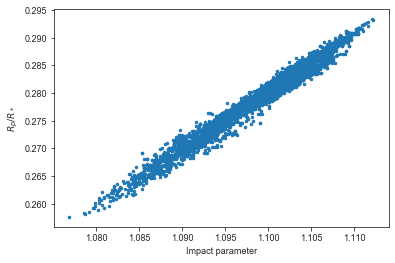

In [11]:
plt.plot(b,p,'.')
plt.xlabel('Impact parameter')
plt.ylabel('$R_p/R_*$')

(0.975, 1.01)

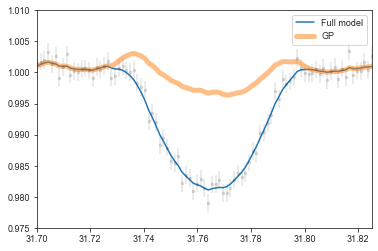

In [12]:
plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)
plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],label='Full model')
plt.plot(dataset.times_lc[sector]-int(tstart), models[sector]/components[sector]['transit'],'-',lw=5,alpha=0.5,label='GP')
plt.legend()
plt.xlim(31.7,31.825)
plt.ylim(0.975,1.01)

That's pretty bad.

### Fit training the GP out-of-transit, then fitting the transit separately



In [16]:
priors = {}

# Name of the parameters to be fit:
params = ['mdilution_TESS4_TESS5', 'mflux_TESS4', 'sigma_w_TESS4', 'GP_sigma_TESS4', 'GP_rho_TESS4', \
          'GP_timescale_TESS4', 'mflux_TESS5', 'sigma_w_TESS5', 'GP_sigma_TESS5', 'GP_rho_TESS5', \
          'GP_timescale_TESS5']

# Distribution for each of the parameters:
dists = ['fixed', 'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform',\
         'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [1.0, [0.,0.1], [0.1, 10000.], [0.1, 10000.], [0.001, 10000.], [0.001, 10000.], \
           [0.,0.1], [0.1, 10000.], [0.1, 10000.], [0.001, 10000.], [0.001, 10000.]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

(0.9066201820969582, 54.27462609810755)

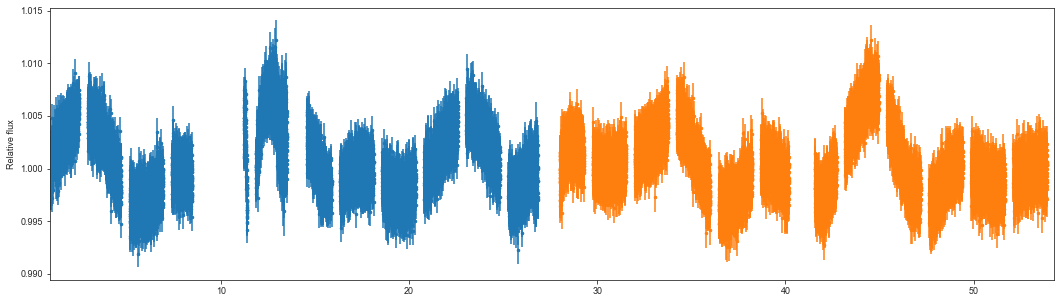

In [19]:
tt, yy, yyerr_lc = {}, {}, {}
plt.figure(figsize=(18,5))
for sector in t.keys():
    phases = juliet.utils.get_phases(t[sector],2.2359835,2456912.35105)
    idx = np.where(np.abs(phases)>0.1)[0]
    tt[sector] = t[sector][idx]
    yy[sector] = f[sector][idx]
    yyerr_lc[sector] = ferr[sector][idx]
    plt.errorbar(tt[sector]-int(tstart),yy[sector],yyerr_lc[sector],fmt='.')
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])

In [20]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = tt, y_lc = yy, \
                      yerr_lc = yyerr_lc, GP_regressors_lc = tt, out_folder = 'WASP-140b-ExpMatern-no-planet')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 500)

  analysing data from WASP-140b-ExpMatern-no-planet/jomnest_.txt


(-5000, 5000)

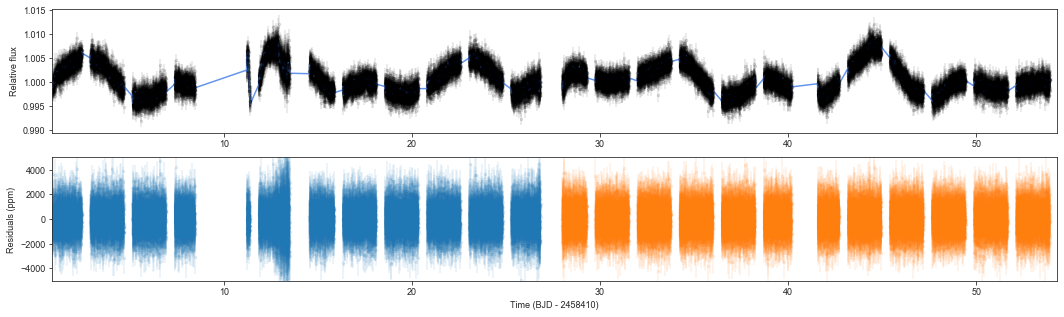

In [21]:
plt.figure(figsize=(18,5))

plt.subplot(211)
# Plot the data:
models = {}
components = {}
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)

    # Plot the model:
    models[sector], components[sector] = results.lc.evaluate(sector, return_components=True)
    plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],color='cornflowerblue')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.subplot(212)
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), (dataset.data_lc[sector] - models[sector])*1e6, \
             yerr = dataset.errors_lc[sector]*1e6, fmt = '.', alpha = 0.1)
    plt.ylabel('Residuals (ppm)')
    plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.ylim([-5000,5000])

Predict flux on the in-transit data:

(0.9066201820969582, 54.27462609810755)

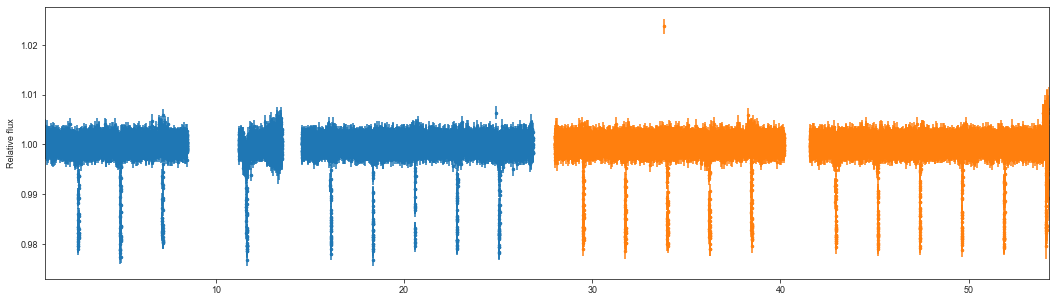

In [36]:
tdet, ydet, ydeterr = {}, {}, {}
model = {}
plt.figure(figsize=(18,5))
for sector in t.keys():
    model[sector] = results.lc.evaluate(sector, t=t[sector], GPregressors=t[sector])
    tdet[sector] = t[sector]
    ydet[sector] = f[sector]/model[sector]
    ydeterr[sector] = ferr[sector]/model[sector]
    plt.errorbar(tdet[sector]-int(tstart),ydet[sector],ydeterr[sector],fmt='.')
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])

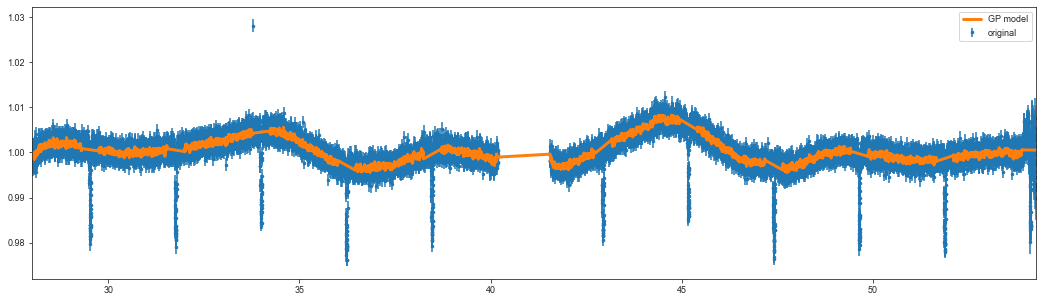

In [59]:
plt.figure(figsize=(18,5))
#plt.errorbar(tdet[sector]-int(tstart),ydet[sector],ydeterr[sector],fmt='k.',alpha=0.1,label='detrended')
plt.errorbar(t[sector]-int(tstart),f[sector],ferr[sector],fmt='.',zorder=1,label='original')
plt.plot(t[sector]-int(tstart),model[sector],'-',lw=3,zorder=2,label='GP model')
plt.xlim([np.min(t[sector]-int(tstart)),tend-int(tstart)])
plt.legend()

(44.75, 45.5)

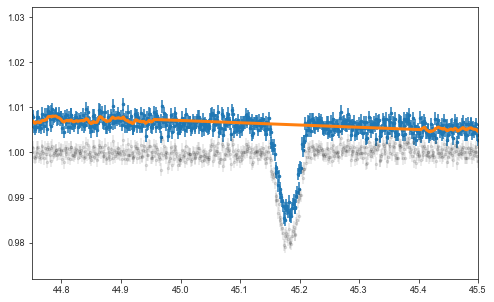

In [52]:
plt.figure(figsize=(8,5))
plt.errorbar(tdet[sector]-int(tstart),ydet[sector],ydeterr[sector],fmt='k.',alpha=0.1)
plt.errorbar(t[sector]-int(tstart),f[sector],ferr[sector],fmt='.',zorder=1)
plt.plot(t[sector]-int(tstart),model[sector],'-',lw=3,zorder=2)
plt.xlim([44.75,45.5])

Fit detrended dataset:

In [60]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS4_TESS5','q2_TESS4_TESS5','ecc_p1','omega_p1',\
          'a_p1', 'mdilution_TESS4_TESS5', 'mflux_TESS4', 'sigma_w_TESS4', 'mflux_TESS5', 'sigma_w_TESS5']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
         'loguniform', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[2.2359835, 0.0000008], [2456912.35105,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0470, 0.,\
           [1,100.], 1.0, 0.0, 265.5155736129, 0.0, 150.4084354290]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [61]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = tdet, y_lc = ydet, \
                      yerr_lc = ydeterr, out_folder = 'WASP-140b-detrended')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 500)

  analysing data from WASP-140b-detrended/jomnest_.txt


(-5000, 5000)

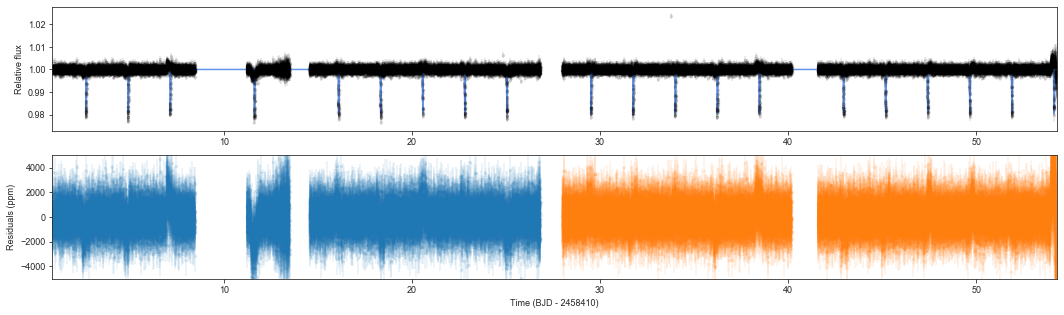

In [62]:
plt.figure(figsize=(18,5))

plt.subplot(211)
# Plot the data:
models = {}
components = {}
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)

    # Plot the model:
    models[sector], components[sector] = results.lc.evaluate(sector, return_components=True)
    plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],color='cornflowerblue')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.subplot(212)
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), (dataset.data_lc[sector] - models[sector])*1e6, \
             yerr = dataset.errors_lc[sector]*1e6, fmt = '.', alpha = 0.1)
    plt.ylabel('Residuals (ppm)')
    plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.ylim([-5000,5000])

(49.5738515, 49.7238515)

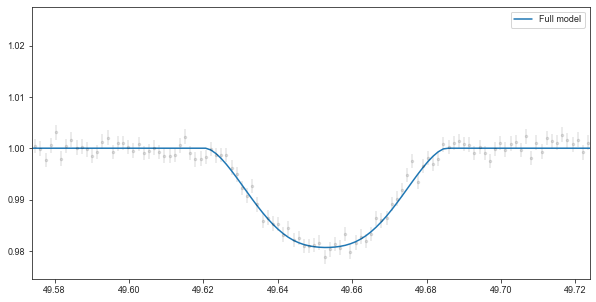

In [84]:
P = 2.2359835
n = 9
plt.figure(figsize=(10,5))
plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)
plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],label='Full model')
#plt.plot(dataset.times_lc[sector]-int(tstart), models[sector]/components[sector]['transit'],'-',lw=5,alpha=0.5,label='GP')
plt.legend()
plt.xlim(29.45+n*P,29.6+n*P)
#plt.ylim(0.975,1.01)

In [63]:
b,p = juliet.utils.reverse_bp(results.posteriors['posterior_samples']['r1_p1'], results.posteriors['posterior_samples']['r2_p1'],0.,1.)

Text(0, 0.5, '$R_p/R_*$')

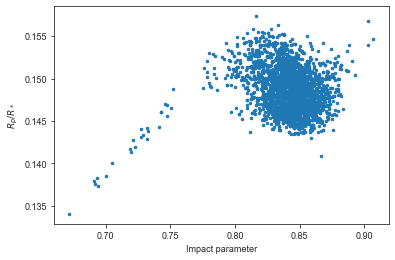

In [64]:
plt.plot(b,p,'.')
plt.xlabel('Impact parameter')
plt.ylabel('$R_p/R_*$')

And...with dilution?

In [91]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS4_TESS5','q2_TESS4_TESS5','ecc_p1','omega_p1',\
          'a_p1', 'mdilution_TESS4_TESS5', 'mflux_TESS4', 'sigma_w_TESS4', 'mflux_TESS5', 'sigma_w_TESS5']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
         'loguniform', 'uniform', 'normal', 'fixed', 'normal', 'fixed']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[2.2359835, 0.0000008], [2456912.35105,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0470, 0.,\
           [1,100.], [0.8,1.0], [0.0,0.1], 265.5155736129, [0.0,0.1], 150.4084354290]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [92]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = tdet, y_lc = ydet, \
                      yerr_lc = ydeterr, out_folder = 'WASP-140b-detrended-diluted')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 500)

  analysing data from WASP-140b-detrended-diluted/jomnest_.txt


(-5000, 5000)

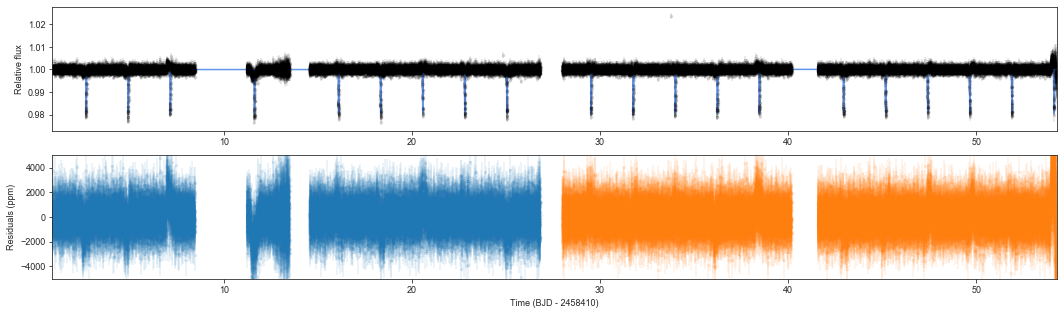

In [93]:
plt.figure(figsize=(18,5))

plt.subplot(211)
# Plot the data:
models = {}
components = {}
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)

    # Plot the model:
    models[sector], components[sector] = results.lc.evaluate(sector, return_components=True)
    plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],color='cornflowerblue')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.subplot(212)
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), (dataset.data_lc[sector] - models[sector])*1e6, \
             yerr = dataset.errors_lc[sector]*1e6, fmt = '.', alpha = 0.1)
    plt.ylabel('Residuals (ppm)')
    plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.ylim([-5000,5000])

(49.5738515, 49.7238515)

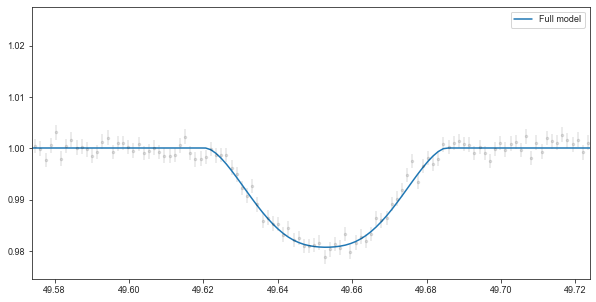

In [94]:
P = 2.2359835
n = 9
plt.figure(figsize=(10,5))
plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)
plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],label='Full model')
#plt.plot(dataset.times_lc[sector]-int(tstart), models[sector]/components[sector]['transit'],'-',lw=5,alpha=0.5,label='GP')
plt.legend()
plt.xlim(29.45+n*P,29.6+n*P)
#plt.ylim(0.975,1.01)

In [95]:
b,p = juliet.utils.reverse_bp(results.posteriors['posterior_samples']['r1_p1'], results.posteriors['posterior_samples']['r2_p1'],0.,1.)

Text(0, 0.5, '$R_p/R_*$')

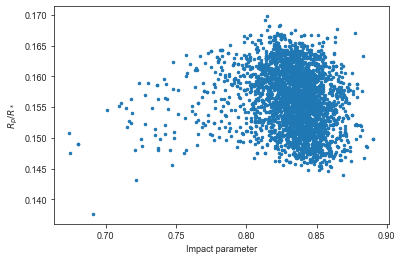

In [96]:
plt.plot(b,p,'.')
plt.xlabel('Impact parameter')
plt.ylabel('$R_p/R_*$')

The residuals plots look funny at the transit locations. Could it be the usage of the `r1` and `r2` parametrization? Let's try again without that:

In [196]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','p_p1','b_p1','q1_TESS4_TESS5','q2_TESS4_TESS5','ecc_p1','omega_p1',\
          'a_p1', 'mdilution_TESS4_TESS5', 'mflux_TESS4', 'sigma_w_TESS4', 'mflux_TESS5', 'sigma_w_TESS5']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
         'loguniform', 'uniform', 'normal', 'fixed', 'normal', 'fixed']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[2.2359835, 0.0000008], [2456912.35105,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0470, 0.,\
           [1,100.], [0.8,1.0], [0.0,0.1], 265.5155736129, [0.0,0.1], 150.4084354290]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [197]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = tdet, y_lc = ydet, \
                      yerr_lc = ydeterr, out_folder = 'WASP-140b-detrended-diluted-no-r1r2')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 500)

(-5000, 5000)

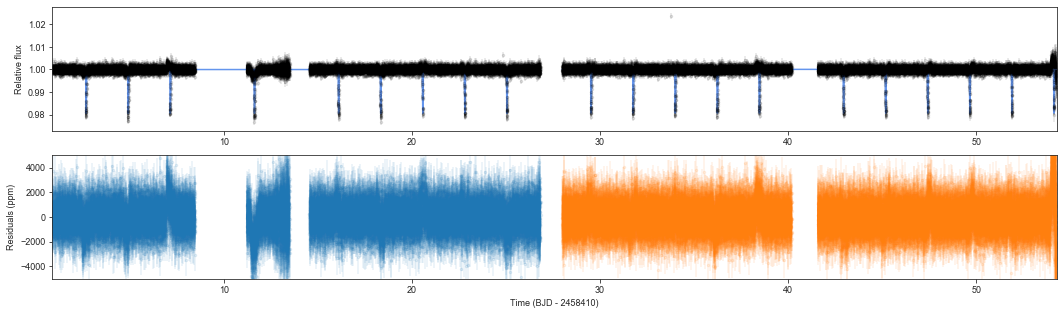

In [198]:
plt.figure(figsize=(18,5))

plt.subplot(211)
# Plot the data:
models = {}
components = {}
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)

    # Plot the model:
    models[sector], components[sector] = results.lc.evaluate(sector, return_components=True)
    plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],color='cornflowerblue')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.subplot(212)
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), (dataset.data_lc[sector] - models[sector])*1e6, \
             yerr = dataset.errors_lc[sector]*1e6, fmt = '.', alpha = 0.1)
    plt.ylabel('Residuals (ppm)')
    plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.ylim([-5000,5000])

In [201]:
b,p = results.posteriors['posterior_samples']['b_p1'], results.posteriors['posterior_samples']['p_p1']

Text(0, 0.5, '$R_p/R_*$')

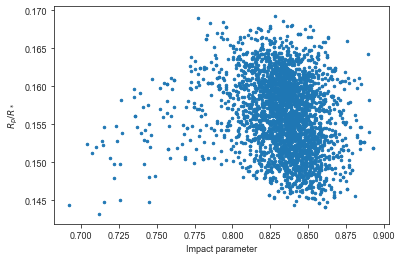

In [202]:
plt.plot(b,p,'.')
plt.xlabel('Impact parameter')
plt.ylabel('$R_p/R_*$')

In [203]:
time0 =  np.copy(dataset.times_lc[sector])
transit_model0 = np.copy(components[sector]['transit'])

Same thing! Why do residuals look funky next to the transits? Let's do some close-ups:

(-5000, 5000)

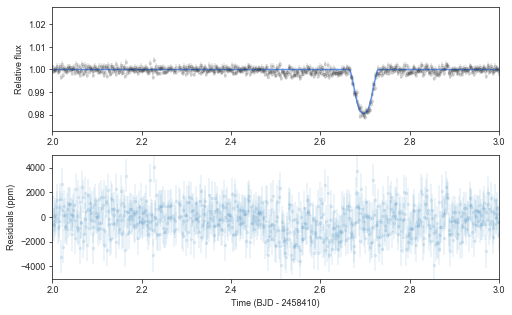

In [116]:
plt.figure(figsize=(8,5))

plt.subplot(211)
# Plot the data:
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)

    # Plot the model:
    #models[sector], components[sector] = results.lc.evaluate(sector, return_components=True)
    plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],color='cornflowerblue')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([2,3])
plt.subplot(212)
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), (dataset.data_lc[sector] - models[sector])*1e6, \
             yerr = dataset.errors_lc[sector]*1e6, fmt = '.', alpha = 0.1)
    plt.ylabel('Residuals (ppm)')
    plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([2,3])
plt.ylim([-5000,5000])

Hmm! It seems to be the entire region (note the time-series looks funky not _at_ the transits, but just before it --- from just after 2.4 and on). To me this seems to be due to the fact that we are trying to predict the variability around the transit using the GP, which models it as a smooth function whereas we really have lots of correlated noise. Let's plot the GP prediction before detrending to test this hypothesis:

(2, 3)

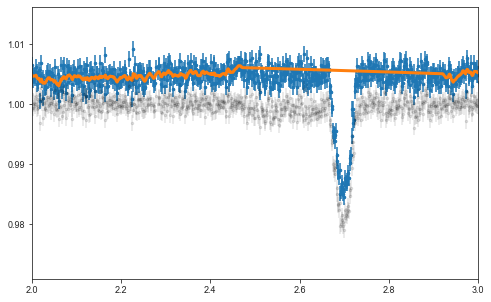

In [115]:
plt.figure(figsize=(8,5))
sector = 'TESS4'
plt.errorbar(tdet[sector]-int(tstart),ydet[sector],ydeterr[sector],fmt='k.',alpha=0.1)
plt.errorbar(t[sector]-int(tstart),f[sector],ferr[sector],fmt='.',zorder=1)
plt.plot(t[sector]-int(tstart),model[sector],'-',lw=3,zorder=2)
plt.xlim([2,3])

Spot-on! Indeed, it seems to be the case. Okay. What if we don't use a GP to predict those regions, but we fit those regions using the out-of-transit posteriors on the GP hyperparameters as priors on the fit? Let's do the full-blown, diluted fit on that. To this end, let's first load the posteriors of the no-planet fit:

In [123]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset_noplanet = juliet.load(input_folder = 'WASP-140b-ExpMatern-no-planet')

# Fit and absorb results into a juliet.fit object:
results_noplanet = dataset_noplanet.fit()

In [124]:
# No-planet posteriors:
posteriors_np = results_noplanet.posteriors['posterior_samples']

In [125]:
print(posteriors_np.keys())

dict_keys(['unnamed', 'loglike', 'mflux_TESS4', 'sigma_w_TESS4', 'GP_sigma_TESS4', 'GP_rho_TESS4', 'GP_timescale_TESS4', 'mflux_TESS5', 'sigma_w_TESS5', 'GP_sigma_TESS5', 'GP_rho_TESS5', 'GP_timescale_TESS5'])


Now generate the prior of the full fit using those posteriors:

In [158]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS4_TESS5','q2_TESS4_TESS5','ecc_p1','omega_p1',\
          'a_p1', 'mdilution_TESS4_TESS5', 'mflux_TESS4', 'sigma_w_TESS4', 'GP_sigma_TESS4', 'GP_rho_TESS4', \
          'GP_timescale_TESS4', 'mflux_TESS5', 'sigma_w_TESS5', 'GP_sigma_TESS5', 'GP_rho_TESS5', \
          'GP_timescale_TESS5']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
         'loguniform', 'uniform', 'normal', 'normal', 'normal', 'normal', 'normal',\
         'normal', 'normal', 'normal', 'normal', 'normal']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[2.2359835, 0.0000008], [2456912.35105,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0470, 0.,\
           [1,100.], [0.8,1.0], [0.0,0.1], [], [], [], [], \
           [0.0,0.1], [], [], [], []]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    if dist is 'normal':
        if len(hyperp) == 0:
            samples = posteriors_np[param]
            hyperp = [np.median(samples),np.sqrt(np.var(samples))]
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

Check all was populated correctly:

In [159]:
for p in priors.keys():
    print(p,priors[p])

P_p1 {'distribution': 'normal', 'hyperparameters': [2.2359835, 8e-07]}
t0_p1 {'distribution': 'normal', 'hyperparameters': [2456912.35105, 0.1]}
r1_p1 {'distribution': 'uniform', 'hyperparameters': [0.0, 1]}
r2_p1 {'distribution': 'uniform', 'hyperparameters': [0.0, 1.0]}
q1_TESS4_TESS5 {'distribution': 'uniform', 'hyperparameters': [0.0, 1.0]}
q2_TESS4_TESS5 {'distribution': 'uniform', 'hyperparameters': [0.0, 1.0]}
ecc_p1 {'distribution': 'fixed', 'hyperparameters': 0.047}
omega_p1 {'distribution': 'fixed', 'hyperparameters': 0.0}
a_p1 {'distribution': 'loguniform', 'hyperparameters': [1, 100.0]}
mdilution_TESS4_TESS5 {'distribution': 'uniform', 'hyperparameters': [0.8, 1.0]}
mflux_TESS4 {'distribution': 'normal', 'hyperparameters': [0.0, 0.1]}
sigma_w_TESS4 {'distribution': 'normal', 'hyperparameters': [265.5155736129273, 7.553891657833276]}
GP_sigma_TESS4 {'distribution': 'normal', 'hyperparameters': [0.11229961958128419, 0.000370814372826202]}
GP_rho_TESS4 {'distribution': 'normal

Cut in-transit data:

(0.9066201820969582, 54.27462609810755)

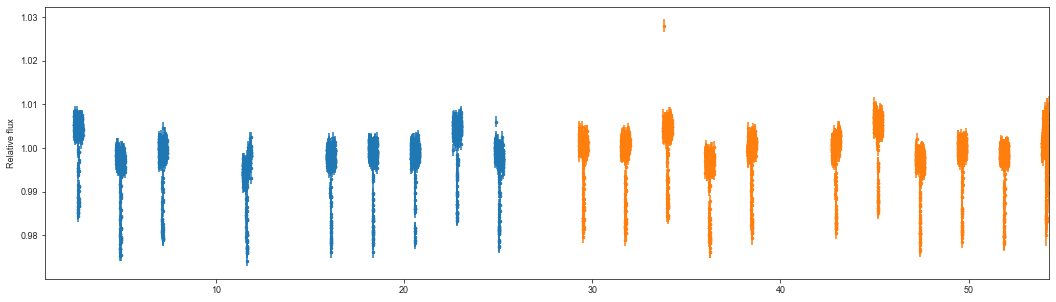

In [160]:
tt_in, yy_in, yyerr_lc_in = {}, {}, {}
plt.figure(figsize=(18,5))
for sector in t.keys():
    phases = juliet.utils.get_phases(t[sector],2.2359835,2456912.35105)
    idx = np.where(np.abs(phases)<=0.1)[0]
    tt_in[sector] = t[sector][idx]
    yy_in[sector] = f[sector][idx]
    yyerr_lc_in[sector] = ferr[sector][idx]
    plt.errorbar(tt_in[sector]-int(tstart),yy_in[sector],yyerr_lc_in[sector],fmt='.')
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])

Aaaaaaaand...fit!

In [175]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = tt_in, y_lc = yy_in, \
                      yerr_lc = yyerr_lc_in, GP_regressors_lc = tt_in, out_folder = 'WASP-140b-ExpMatern-with-planet')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 500)

(-5000, 5000)

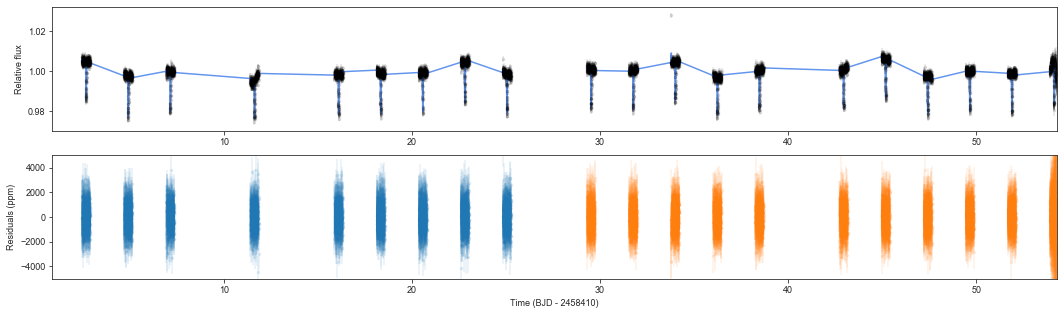

In [176]:
plt.figure(figsize=(18,5))

plt.subplot(211)
# Plot the data:
models = {}
components = {}
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)

    # Plot the model:
    models[sector], components[sector] = results.lc.evaluate(sector, return_components=True)
    plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],color='cornflowerblue')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.subplot(212)
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), (dataset.data_lc[sector] - models[sector])*1e6, \
             yerr = dataset.errors_lc[sector]*1e6, fmt = '.', alpha = 0.1)
    plt.ylabel('Residuals (ppm)')
    plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.ylim([-5000,5000])

(-5000, 5000)

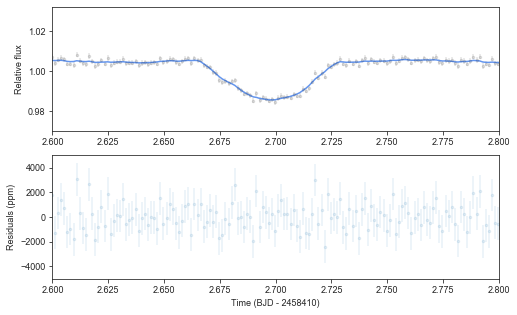

In [177]:
plt.figure(figsize=(8,5))

plt.subplot(211)
# Plot the data:
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)

    # Plot the model:
    #models[sector], components[sector] = results.lc.evaluate(sector, return_components=True)
    plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],color='cornflowerblue')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([2.6,2.8])
plt.subplot(212)
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), (dataset.data_lc[sector] - models[sector])*1e6, \
             yerr = dataset.errors_lc[sector]*1e6, fmt = '.', alpha = 0.1)
    plt.ylabel('Residuals (ppm)')
    plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([2.6,2.8])
plt.ylim([-5000,5000])

In [178]:
b,p = juliet.utils.reverse_bp(results.posteriors['posterior_samples']['r1_p1'], results.posteriors['posterior_samples']['r2_p1'],0.,1.)

Text(0, 0.5, '$R_p/R_*$')

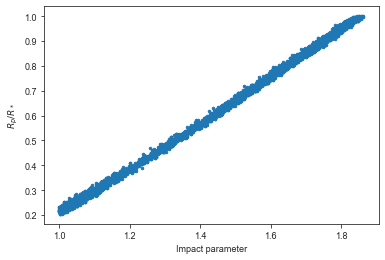

In [179]:
plt.plot(b,p,'.')
plt.xlabel('Impact parameter')
plt.ylabel('$R_p/R_*$')

(0.975, 1.01)

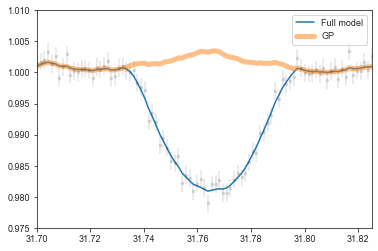

In [180]:
plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)
plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],label='Full model')
plt.plot(dataset.times_lc[sector]-int(tstart), models[sector]/components[sector]['transit'],'-',lw=5,alpha=0.5,label='GP')
plt.legend()
plt.xlim(31.7,31.825)
plt.ylim(0.975,1.01)

Let's remove the GP and save the model for later comparison:

In [181]:
transit_model1 = np.copy(components[sector]['transit'])

Interesting. Again with no r1/r2 parametrization:

In [182]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','b_p1','p_p1','q1_TESS4_TESS5','q2_TESS4_TESS5','ecc_p1','omega_p1',\
          'a_p1', 'mdilution_TESS4_TESS5', 'mflux_TESS4', 'sigma_w_TESS4', 'GP_sigma_TESS4', 'GP_rho_TESS4', \
          'GP_timescale_TESS4', 'mflux_TESS5', 'sigma_w_TESS5', 'GP_sigma_TESS5', 'GP_rho_TESS5', \
          'GP_timescale_TESS5']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
         'loguniform', 'uniform', 'normal', 'normal', 'normal', 'normal', 'normal',\
         'normal', 'normal', 'normal', 'normal', 'normal']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[2.2359835, 0.0000008], [2456912.35105,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0470, 90.,\
           [1,100.], [0.8,1.0], [0.0,0.1], [], [], [], [], \
           [0.0,0.1], [], [], [], []]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    if dist is 'normal':
        if len(hyperp) == 0:
            samples = posteriors_np[param]
            hyperp = [np.median(samples),np.sqrt(np.var(samples))]
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [183]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = tt_in, y_lc = yy_in, \
                      yerr_lc = yyerr_lc_in, GP_regressors_lc = tt_in, out_folder = 'WASP-140b-ExpMatern-with-planet-nor1r2')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 500)

(-5000, 5000)

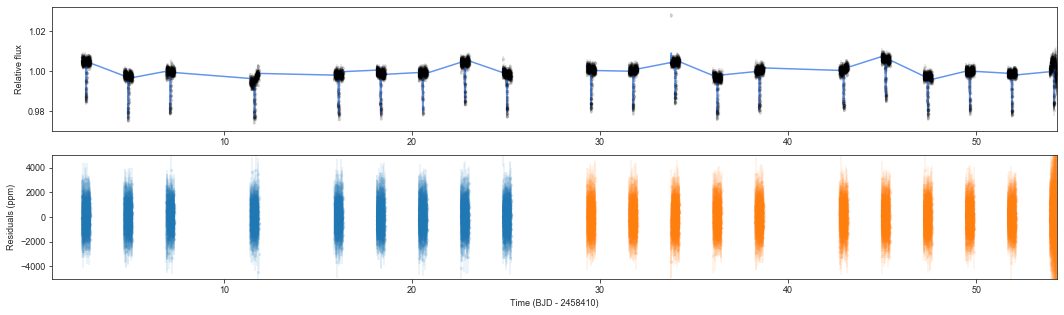

In [184]:
plt.figure(figsize=(18,5))

plt.subplot(211)
# Plot the data:
models = {}
components = {}
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)

    # Plot the model:
    models[sector], components[sector] = results.lc.evaluate(sector, return_components=True)
    plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],color='cornflowerblue')

# Plot portion of the lightcurve, axes, etc.:
plt.ylabel('Relative flux')
plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.subplot(212)
for sector in t.keys():
    plt.errorbar(dataset.times_lc[sector]-int(tstart), (dataset.data_lc[sector] - models[sector])*1e6, \
             yerr = dataset.errors_lc[sector]*1e6, fmt = '.', alpha = 0.1)
    plt.ylabel('Residuals (ppm)')
    plt.xlabel(f'Time (BJD - {int(tstart)})')

plt.xlim([tstart-int(tstart),tend-int(tstart)])
plt.ylim([-5000,5000])

In [185]:
b,p = results.posteriors['posterior_samples']['b_p1'], results.posteriors['posterior_samples']['p_p1']

Text(0, 0.5, '$R_p/R_*$')

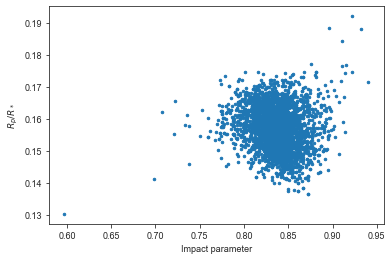

In [186]:
plt.plot(b,p,'.')
plt.xlabel('Impact parameter')
plt.ylabel('$R_p/R_*$')

(0.975, 1.01)

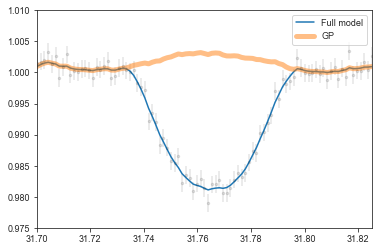

In [187]:
plt.errorbar(dataset.times_lc[sector]-int(tstart), dataset.data_lc[sector], \
                 yerr = dataset.errors_lc[sector], fmt = 'k.', alpha = 0.1)
plt.plot(dataset.times_lc[sector]-int(tstart), models[sector],label='Full model')
plt.plot(dataset.times_lc[sector]-int(tstart), models[sector]/components[sector]['transit'],'-',lw=5,alpha=0.5,label='GP')
plt.legend()
plt.xlim(31.7,31.825)
plt.ylim(0.975,1.01)

In [188]:
transit_model2 = np.copy(components[sector]['transit'])

OK. Interestingly results more or less agree --- but still don't match Hellier et al.'s paper. Let's compare the (phased) transit models:

In [189]:
phases = juliet.utils.get_phases(dataset.times_lc[sector],2.2359834875,2456912.3523935727)

(-0.025, 0.025)

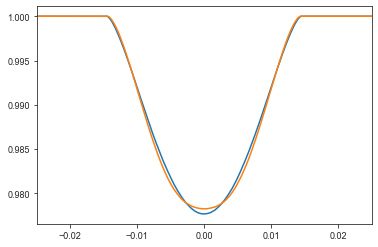

In [190]:
idx_phases = np.argsort(phases)
plt.plot(phases[idx_phases],transit_model1[idx_phases],'-')
plt.plot(phases[idx_phases],transit_model2[idx_phases],'-')
plt.xlim(-0.025,0.025)

### Fitting all data simultaneously

It is not exactly clear what is going on to be completely honest. Different ways of handling the TESS data give rise to different results for this system, and _none_ of them agree with Hellier et al.'s results. So let's go ahead and re-fit part of the Hellier et al. dataset. I searched everywhere, and the TRAPPIST photometry published in that paper is nowhere to be found. We could use the WASP lightcurve, but it seems the quality sould be pretty bad and not help in any way on the analysis. We'll use, however, a stellar density prior based on the results of their paper --- $\rho_* = 1.38 \pm 0.18 \rho_{\odot}$, which implies $\rho_* = 1951 \pm 252 $ kg/m$^3$. 

We'll fit the RV's simultaneously as well; and use a diluted transit depth:

In [209]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS4_TESS5','q2_TESS4_TESS5','sesinomega_p1','secosomega_p1',\
          'rho', 'mdilution_TESS4_TESS5', 'mflux_TESS4', 'sigma_w_TESS4', 'GP_sigma_TESS4', 'GP_rho_TESS4', \
          'GP_timescale_TESS4', 'mflux_TESS5', 'sigma_w_TESS5', 'GP_sigma_TESS5', 'GP_rho_TESS5', \
          'GP_timescale_TESS5','K_p1','mu_CORALIE','sigma_w_CORALIE']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','uniform','uniform',\
         'normal', 'uniform', 'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform',\
         'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform','uniform','uniform','loguniform']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[2.2359835, 0.0000008], [2456912.35105,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], [-1.,1.], [-1.,1.],\
           [1951.,252.], [0.8,1.], [0.,0.1], [0.1, 10000.], [0.1, 10000.], [0.001, 10000.], [0.001, 10000.], \
           [0.,0.1], [0.1, 10000.], [0.1, 10000.], [0.001, 10000.], [0.001, 10000.],[0.,1000],[-1000.,1000],[0.01,1000]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

In [ ]:
# Load dataset into juliet, save results to a temporary folder called toi141_fit:
dataset = juliet.load(priors=priors, t_lc = t, y_lc = f, \
                      yerr_lc = ferr, GP_regressors_lc = t, rvfilename='extra_data/rvs_w140.dat', \
                      out_folder = 'WASP-140b-TESS-RVs')

# Fit and absorb results into a juliet.fit object:
results = dataset.fit(n_live_points = 500)